# Surfa Data Preparation Notebook

This notebook 
* reads in the the raw data, 
* applies appropriate transformations, 
* executes the appropriate feature engeneering, 
* cleans the data and
* stores it in a dataset that can be used in training the model.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max.columns', None)

In [2]:
tips = pd.read_csv('raw_data/raw_tips.csv', parse_dates=False)
tips.info()
tips.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      101 non-null    object 
 1   Tip       101 non-null    float64
 2   Orders    101 non-null    int64  
 3   Distance  101 non-null    float64
 4   DriverID  101 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 4.1+ KB


,Date,Tip,Orders,Distance,DriverID
0,2021-01-10,0.00,8,28.0,1
1,2021-01-02,0.00,5,13.9,1
2,2021-01-13,0.00,8,20.0,1
3,2021-01-16,0.00,10,30.0,1
4,2021-01-21,2.45,11,37.5,1


## Auditing and cleaning

`tips` is the only dataset that requires cleaning since all the other ones were already cleanend. 

The following functions are used to audit the dataset. Data types, upper bounds, lower bounds, and business rules are being taken into account.

In [3]:
def audit_surfa(df):
    print('Start audit')
    assure_num_type(df,'Tip', float, min=0, max=200)
    assure_num_type(df,'Distance', float, min=0, max=100)
    assure_num_type(df,'Orders', int, min=0, max=50)
    assure_num_type(df,'DriverID', int, min=0)
    assure_date(df, 'Date', min='2020-09-01', max='2021-03-18')
    assure_mandatory(df, df.columns)
    assure_orders_exist_for_tips(df)
    print('Audit completed')

# Assure that df[col] is of dtype data type
def assure_num_type(df, col, dtype, min= None, max=None):
    df[col] = df[col].astype(dtype)

    assure_min(df, col, min)
    assure_max(df, col, max)

# Assure that df[col] is higher than df[col]
def assure_min(df, col, min):
    lower = df[col] < min
    if lower.any(): 
        print('Fail! #ValueTooLow', col, '\n', df.loc[lower])

# Assure that df[col] is not higher than max
def assure_max(df, col, max):
    higher = df[col] > max
    if higher.any(): 
        print('Fail! #ValueTooHigh', col, '\n', df.loc[higher])

# Assure that df[col] is a data between min and max
def assure_date(df, col, min=None, max=None):
    try:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='raise')
    except ValueError as error:
        print('Fail! #DateFormatWrong (expected yyyy-mm-dd)', col, '\n', error)

    assure_min(df, col, min)
    assure_max(df, col, max)

# Assure that df[col] has no missing values
def assure_mandatory(df, cols):

    invalid = df[cols].isna().any(axis=1)
    if invalid.any():
        print('Fail! #MissingValues ', cols, '\n', df.loc[invalid] )

# Assure that all shifts that have a tip also have one or more orders
def assure_orders_exist_for_tips(df):
    invalid = (df['Tip'] > 0) & (df['Orders'] == 0)
    if invalid.any():
        print('Warning! #NoOrdersForTip \n', df.loc[invalid])
    return invalid


audit_surfa(tips)

Start audit
Warning! #NoOrdersForTip 
          Date   Tip  Orders  Distance  DriverID
37 2021-01-31  2.32       0       0.0         2
Audit completed


This function automatically fixes data that failed the audit

In [4]:
# Automatically fix audit fails that can be fixed
def autofix_data(df: pd.DataFrame) -> pd.DataFrame:
    todrop = assure_orders_exist_for_tips(df)
    df = df.loc[~todrop]

    print('Autofixing finished')
    return df

tips = autofix_data(tips)


Warning! #NoOrdersForTip 
          Date   Tip  Orders  Distance  DriverID
37 2021-01-31  2.32       0       0.0         2
Autofixing finished


# Enreaching tips dataset

Add `TipPerOrder` as label to normalize the tips by the number of orders, because some drivers may have double shifts, earning twice as many tips, but we do not want our model to think that day was twice as profitable.

In [5]:
tips['TipPerOrder'] = tips['Tip'] / tips['Orders']
tips.head(5)

,Date,Tip,Orders,Distance,DriverID,TipPerOrder
0,2021-01-10,0.00,8,28.0,1,0.000000
1,2021-01-02,0.00,5,13.9,1,0.000000
2,2021-01-13,0.00,8,20.0,1,0.000000
3,2021-01-16,0.00,10,30.0,1,0.000000
4,2021-01-21,2.45,11,37.5,1,0.222727


On the second itteration we realized that `TipPerOrder` has its own problems, such as:
*   The days with less orders seem more profitable, even if the same time is spent
*   Factors like bad weather and pute chance may affect the number of orders a driver can take, making the day seem more or less profitable than it actually is.

To combat this we introduce a new label `TipPerHour` which divides the tip received by the number of shifts, assuming that rows with 16 orders or less are one shift (5 hours) and everything more is 2 shifts (8 hours)

In [6]:
tips['Hours'] = tips['Orders'].apply( lambda orders: 5 if orders <= 16 else 8)
tips['TipPerHour'] = tips['Tip'] / tips['Hours']
tips.head(3)

,Date,Tip,Orders,Distance,DriverID,TipPerOrder,Hours,TipPerHour
0,2021-01-10,0.0,8,28.0,1,0.0,5,0.0
1,2021-01-02,0.0,5,13.9,1,0.0,5,0.0
2,2021-01-13,0.0,8,20.0,1,0.0,5,0.0


Add the day of the week and a flag for wheter the shift is during a weekend (Friday included) or not.

In [7]:
tips['DayOfWeek'] = tips['Date'].dt.dayofweek
tips['IsWeekend'] = (tips['DayOfWeek'] > 3).astype(float) # 4, 5, 6 are Fri, Sat, Sun respectievely, and considered weekend
tips.head(5)

,Date,Tip,Orders,Distance,DriverID,TipPerOrder,Hours,TipPerHour,DayOfWeek,IsWeekend
0,2021-01-10,0.00,8,28.0,1,0.000000,5,0.00,6,1.0
1,2021-01-02,0.00,5,13.9,1,0.000000,5,0.00,5,1.0
2,2021-01-13,0.00,8,20.0,1,0.000000,5,0.00,2,0.0
3,2021-01-16,0.00,10,30.0,1,0.000000,5,0.00,5,1.0
4,2021-01-21,2.45,11,37.5,1,0.222727,5,0.49,3,0.0


# KNMI Weather Data 

Now we will load the KNMI dayly dataset to have meteorological data about the shifts.

In [18]:
weather_cols = {
    'FG': 'MeanWind',
    'FHX': 'MaxWind',
    'FHXH': 'MaxWindHour',
    'FHN': 'MinWind',
    'FHNH': 'MinWindHour',
    'FXX': 'MaxWindGust',
    'FXXH': 'MaxWindGustHour',
    'TG': 'MeanTemp',
    'TN': 'MinTemp',
    'TNH': 'MinTempHour',
    'TX': 'MaxTemp',
    'TXH': 'MaxTempHour',
    'SQ': 'SunshineDur',
    'DR': 'RainDur',
    'RH': 'RainAmount',
    'RHX': 'MaxRainAmount',
    'RHXH': 'MaxRainAmountHour',
    'PG': 'MeanPress',
    'PX': 'MaxPress',
    'PXH': 'MaxPressHour',
    'PN': 'MinPress',
    'PNH': 'MinPressHour',
    'VVN': 'MinVis',
    'VVNH': 'MinVisHour',
    'VVX': 'MaxVis',
    'VVXH': 'MaxVisHour',
    'NG': 'Cloudness',
    'UG': 'MeanHum',
    'UX': 'MaxHum',
    'UXH': 'MaxHumHour',
    'UN': 'MinHum',
    'UNH': 'MinHumHour',
}

weather = pd.read_csv('https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_370.zip', parse_dates=['YYYYMMDD'], index_col=['YYYYMMDD'], na_values='     ', header=44, dtype=float, converters = {'YYYYMMDD': str} )
print(weather.shape)
weather = weather.loc['2020-01-01':] \
            .drop(columns=['# STN']) \
            .rename(columns=str.strip) \
            .rename(columns=weather_cols)
weather.loc[:,].head(5)

<ipython-input-18-9c212fdb3671>:36: ParserWarning: Both a converter and dtype were specified for column YYYYMMDD - only the converter will be used
  weather = pd.read_csv('https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_370.zip', parse_dates=['YYYYMMDD'], index_col=['YYYYMMDD'], na_values='     ', header=44, dtype=float, converters = {'YYYYMMDD': str} )


(25683, 40)


,DDVEC,FHVEC,MeanWind,MaxWind,MaxWindHour,MinWind,MinWindHour,MaxWindGust,MaxWindGustHour,MeanTemp,MinTemp,MinTempHour,MaxTemp,MaxTempHour,T10N,T10NH,SunshineDur,SP,Q,RainDur,RainAmount,MaxRainAmount,MaxRainAmountHour,MeanPress,MaxPress,MaxPressHour,MinPress,MinPressHour,MinVis,MinVisHour,MaxVis,MaxVisHour,Cloudness,MeanHum,MaxHum,MaxHumHour,MinHum,MinHumHour,EV24
YYYYMMDD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,159.0,16.0,21.0,40.0,24.0,10.0,17.0,70.0,24.0,6.0,-12.0,21.0,35.0,1.0,-10.0,24.0,0.0,0.0,131.0,0.0,0.0,0.0,1.0,10320.0,10341.0,1.0,10299.0,24.0,1.0,10.0,37.0,1.0,8.0,97.0,98.0,6.0,92.0,1.0,1.0
2020-01-02,182.0,37.0,38.0,50.0,19.0,20.0,4.0,90.0,19.0,37.0,5.0,1.0,77.0,24.0,6.0,6.0,0.0,0.0,124.0,0.0,0.0,0.0,1.0,10250.0,10294.0,1.0,10196.0,24.0,4.0,1.0,70.0,16.0,8.0,94.0,98.0,1.0,87.0,23.0,2.0
2020-01-03,232.0,40.0,53.0,70.0,9.0,30.0,19.0,120.0,14.0,76.0,26.0,24.0,101.0,15.0,12.0,24.0,0.0,0.0,68.0,64.0,49.0,18.0,13.0,10202.0,10289.0,23.0,10157.0,12.0,33.0,17.0,70.0,1.0,7.0,91.0,96.0,14.0,84.0,8.0,1.0
2020-01-04,249.0,43.0,45.0,60.0,9.0,20.0,22.0,100.0,12.0,56.0,20.0,1.0,82.0,13.0,11.0,6.0,7.0,9.0,201.0,31.0,9.0,4.0,19.0,10309.0,10343.0,24.0,10287.0,1.0,30.0,19.0,74.0,14.0,8.0,92.0,97.0,21.0,80.0,14.0,3.0
2020-01-05,213.0,32.0,32.0,40.0,11.0,30.0,1.0,60.0,13.0,65.0,58.0,6.0,74.0,13.0,56.0,6.0,0.0,0.0,99.0,0.0,-1.0,-1.0,1.0,10340.0,10353.0,10.0,10314.0,24.0,50.0,4.0,75.0,13.0,8.0,87.0,95.0,1.0,77.0,13.0,1.0


In [19]:
df  = tips.join(weather, on='Date')
df.head(5)

,Date,Tip,Orders,Distance,DriverID,TipPerOrder,Hours,TipPerHour,DayOfWeek,IsWeekend,DDVEC,FHVEC,MeanWind,MaxWind,MaxWindHour,MinWind,MinWindHour,MaxWindGust,MaxWindGustHour,MeanTemp,MinTemp,MinTempHour,MaxTemp,MaxTempHour,T10N,T10NH,SunshineDur,SP,Q,RainDur,RainAmount,MaxRainAmount,MaxRainAmountHour,MeanPress,MaxPress,MaxPressHour,MinPress,MinPressHour,MinVis,MinVisHour,MaxVis,MaxVisHour,Cloudness,MeanHum,MaxHum,MaxHumHour,MinHum,MinHumHour,EV24
0,2021-01-10,0.00,8,28.0,1,0.000000,5,0.00,6,1.0,208.0,20.0,20.0,30.0,12.0,10.0,1.0,50.0,24.0,4.0,-38.0,2.0,47.0,14.0,-56.0,6.0,50.0,61.0,392.0,0.0,0.0,0.0,1.0,10244.0,10254.0,1.0,10230.0,24.0,3.0,1.0,65.0,14.0,6.0,94.0,99.0,1.0,79.0,14.0,4.0
1,2021-01-02,0.00,5,13.9,1,0.000000,5,0.00,5,1.0,190.0,16.0,22.0,30.0,1.0,10.0,15.0,50.0,1.0,28.0,13.0,6.0,38.0,14.0,11.0,6.0,0.0,0.0,112.0,4.0,2.0,2.0,4.0,10139.0,10151.0,24.0,10125.0,1.0,14.0,20.0,59.0,1.0,8.0,95.0,98.0,17.0,92.0,2.0,1.0
2,2021-01-13,0.00,8,20.0,1,0.000000,5,0.00,2,0.0,250.0,36.0,38.0,60.0,12.0,20.0,24.0,90.0,11.0,30.0,-1.0,1.0,54.0,13.0,-12.0,6.0,22.0,27.0,299.0,0.0,-1.0,-1.0,1.0,10165.0,10180.0,3.0,10149.0,17.0,50.0,23.0,73.0,14.0,8.0,89.0,96.0,24.0,78.0,14.0,4.0
3,2021-01-16,0.00,10,30.0,1,0.000000,5,0.00,5,1.0,182.0,32.0,33.0,50.0,12.0,10.0,5.0,120.0,15.0,2.0,-9.0,16.0,19.0,12.0,-8.0,18.0,0.0,0.0,149.0,68.0,33.0,8.0,16.0,10231.0,10300.0,1.0,10158.0,24.0,19.0,17.0,81.0,13.0,8.0,86.0,98.0,17.0,63.0,14.0,2.0
4,2021-01-21,2.45,11,37.5,1,0.222727,5,0.49,3,0.0,203.0,74.0,82.0,130.0,3.0,30.0,19.0,230.0,3.0,80.0,53.0,24.0,129.0,3.0,49.0,12.0,9.0,10.0,270.0,74.0,101.0,25.0,20.0,9883.0,9925.0,10.0,9827.0,22.0,37.0,24.0,83.0,1.0,7.0,78.0,95.0,19.0,58.0,2.0,4.0


## Enriching with hourly weather data

We will also use a different dataset to get hourly data about the weather during the shifts.

In [20]:
hourly_weather_cols = {
    'YYYYMMDD': 'Date',
    'HH': 'Hour',
    'DD': 'WindDirection',
    'FH': 'MeanWind',
    'FF': 'MeanWindBefore',
    'FX': 'HighestWind',
    'T': 'Temperature',
    'T10N': 'AltitudeTemperature',
    'TD': 'DewTemperature',
    'Q': 'GlobalRadiation',
    'DR': 'PrecipitationDuration',
    'RH': 'PrecipitationAmount',
    'P': 'AtmosphericPressure',
    'VV': 'Visibility',
    'N': 'Cloudiness',
    'U': 'Hummidity',
    'WW': 'WeatherCode',
    'IX': 'WeatherCodeSource',
    'M': 'Mist',
    'R': 'Rain',
    'S': 'Snow',
    'O': 'Thunder',
    'Y': 'Ice'
}


uurweer1 = pd.read_csv('https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/uurgegevens/uurgeg_370_2011-2020.zip', parse_dates=['YYYYMMDD'],  na_values='     ', header=28, dtype=float, converters = {'YYYYMMDD': str} )
uurweer2 = pd.read_csv('https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/uurgegevens/uurgeg_370_2021-2030.zip', parse_dates=['YYYYMMDD'],  na_values='     ', header=28, dtype=float, converters = {'YYYYMMDD': str} )

uurweer = pd.concat([uurweer1, uurweer2])

uurweer = uurweer.drop(columns=['# STN']) \
    .rename(columns=str.strip) \
    .rename(columns={
        **weather_cols,
        **hourly_weather_cols,
    })

uurweer = uurweer.loc[uurweer['Date'] > '2020-06-01']

uurweer.head(5)

<ipython-input-20-136f46dec062>:28: ParserWarning: Both a converter and dtype were specified for column YYYYMMDD - only the converter will be used
  uurweer1 = pd.read_csv('https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/uurgegevens/uurgeg_370_2011-2020.zip', parse_dates=['YYYYMMDD'],  na_values='     ', header=28, dtype=float, converters = {'YYYYMMDD': str} )
<ipython-input-20-136f46dec062>:29: ParserWarning: Both a converter and dtype were specified for column YYYYMMDD - only the converter will be used
  uurweer2 = pd.read_csv('https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/uurgegevens/uurgeg_370_2021-2030.zip', parse_dates=['YYYYMMDD'],  na_values='     ', header=28, dtype=float, converters = {'YYYYMMDD': str} )


,Date,Hour,WindDirection,MeanWind,MeanWindBefore,HighestWind,Temperature,AltitudeTemperature,DewTemperature,SunshineDur,GlobalRadiation,PrecipitationDuration,PrecipitationAmount,AtmosphericPressure,Visibility,Cloudiness,Hummidity,WeatherCode,WeatherCodeSource,Mist,Rain,Snow,Thunder,Ice
82560,2020-06-02,1.0,0.0,10.0,0.0,20.0,124.0,NaN,66.0,0.0,0.0,0.0,0.0,10192.0,80.0,8.0,67.0,NaN,5.0,0.0,0.0,0.0,0.0,0.0
82561,2020-06-02,2.0,990.0,0.0,10.0,10.0,113.0,NaN,67.0,0.0,0.0,0.0,0.0,10190.0,75.0,8.0,73.0,NaN,5.0,0.0,0.0,0.0,0.0,0.0
82562,2020-06-02,3.0,0.0,0.0,0.0,30.0,100.0,NaN,67.0,0.0,0.0,0.0,0.0,10188.0,75.0,8.0,80.0,NaN,5.0,0.0,0.0,0.0,0.0,0.0
82563,2020-06-02,4.0,0.0,0.0,0.0,10.0,98.0,NaN,70.0,0.0,3.0,0.0,0.0,10188.0,70.0,8.0,82.0,NaN,5.0,0.0,0.0,0.0,0.0,0.0
82564,2020-06-02,5.0,0.0,0.0,0.0,20.0,140.0,NaN,84.0,10.0,35.0,0.0,0.0,10191.0,80.0,8.0,69.0,NaN,5.0,0.0,0.0,0.0,0.0,0.0


Now we will add a few columns to the daset based on the hourly weather. 

Since we do not know at what time of the day the shift occured, and it is not possible to find out, we will look into a number of features that interest us: 'Ice', 'Thunder', 'Snow', 'Rain', 'Mist' at different times in the day: the whole 24h, the working day (12:00-22:00), noon, afternoon, evening, first shift, last shift etc.

The columns will have names like 'IceAfternoon', 'MistDay', 'Mist' and 'ThunferEvening'

In [21]:
# returns a function that takes in a date and returns true if the specified `feature` is true in uurweer on the given day, anywhere between `start` and `stop`
def any_bool_in_interval(feature: str, start:int, end:int):
    return lambda day: uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= start)  & (uurweer.Hour <= end)][feature].any()

for feature in ['Ice', 'Thunder', 'Snow', 'Rain', 'Mist']:
    df[feature] = df.Date.apply( any_bool_in_interval(feature, 0, 24))
    df[feature + 'Day'] = df.Date.apply( any_bool_in_interval(feature, 12, 22))
    df[feature + 'Noon'] = df.Date.apply( any_bool_in_interval(feature, 12, 15))
    df[feature + 'Afternoon'] = df.Date.apply( any_bool_in_interval(feature, 16, 18))
    df[feature + 'Evening'] = df.Date.apply( any_bool_in_interval(feature, 19, 21))
    df[feature + 'First'] = df.Date.apply( any_bool_in_interval(feature, 13, 17))
    df[feature + 'Last'] = df.Date.apply( any_bool_in_interval(feature, 17, 22))

df.loc[:,'Ice':].head(5)

,Ice,IceDay,IceNoon,IceAfternoon,IceEvening,IceFirst,IceLast,Thunder,ThunderDay,ThunderNoon,ThunderAfternoon,ThunderEvening,ThunderFirst,ThunderLast,Snow,SnowDay,SnowNoon,SnowAfternoon,SnowEvening,SnowFirst,SnowLast,Rain,RainDay,RainNoon,RainAfternoon,RainEvening,RainFirst,RainLast,Mist,MistDay,MistNoon,MistAfternoon,MistEvening,MistFirst,MistLast
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,True,False,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,False,True,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,True,False,True,False,False,False,False,False,False,False


Since many of the added columns have few rows that are True, most being false, we cannot relyably use them as fetures because they are susceptable to anomalies.

We will remove all columns that have less than 7 true values.

In [22]:
untrusted = df.loc[:, 'Ice':'MistLast'].sum()
untrusted = untrusted.loc[untrusted <= 7]
df.drop(columns=untrusted.index, inplace=True, errors='ignore')

df.loc[:,'Ice':].head(5)


,Ice,Snow,Rain,RainDay,RainNoon,RainAfternoon,RainEvening,RainFirst,RainLast,Mist
0,True,False,False,False,False,False,False,False,False,True
1,False,False,True,True,False,False,True,False,True,False
2,False,False,True,False,False,False,False,False,False,False
3,True,True,True,True,False,False,True,False,True,False
4,False,False,True,True,False,True,True,False,True,False


We will also add the mean values for numerical columns in a process similar to the one before but for columns: 'MeanWind', 'Visibility', 'PrecipitationAmount', 'Hummidity', 'Cloudiness', 'HighestWind', 'Temperature', 'WeatherCode'

In [23]:
for feature in ['MeanWind', 'Visibility', 'PrecipitationAmount', 'Hummidity', 'Cloudiness', 'HighestWind', 'Temperature', 'WeatherCode']:
    df[feature + 'Day'] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 12)  & (uurweer.Hour <= 20)][feature].mean())
    df[feature + 'Noon'] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 12)  & (uurweer.Hour <= 15)][feature].mean())
    df[feature + 'Afternoon'] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 16)  & (uurweer.Hour <= 18)][feature].mean())
    df[feature + 'Evening'] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 19)  & (uurweer.Hour <= 21)][feature].mean())
    df[feature + 'Last'] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 17)  & (uurweer.Hour <= 21)][feature].mean())


We are also interested in the max and min `WeatherCode` since higher weather codes meane more severe weather conditions

In [24]:
for feature in ['WeatherCode']:
    df['Max' + feature] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 1)  & (uurweer.Hour <= 24)][feature].max())
    df['Max' +feature + 'Day'] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 12)  & (uurweer.Hour <= 22)][feature].max())
    df['Min' + feature] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 1)  & (uurweer.Hour <= 24)][feature].min())
    df['Min' + feature + 'Day'] = df.Date.apply( lambda day : uurweer.loc[(uurweer.Date == day) & (uurweer.Hour >= 12)  & (uurweer.Hour <= 22)][feature].min())


We consider any `WeatherCode` above 79 as "Heavy weather"

In [25]:
df['HeavyWeather'] = df.Date.apply( lambda day: ((uurweer.Date == day) & (uurweer.Hour >= 1)  & (uurweer.Hour <= 24) & (uurweer.WeatherCode >= 79)).any())

Now we will look which of the added features have the best correlation with our label.

In this case those are: 'IsWeekend', 'DayOfWeek', 'MaxWindHour', 'MaxWindGustHour', 'MaxHum', 'VisibilityNoon'.

'Orders', 'WeatherCodeAfternoon' and 'Distance' cannot be used as features.


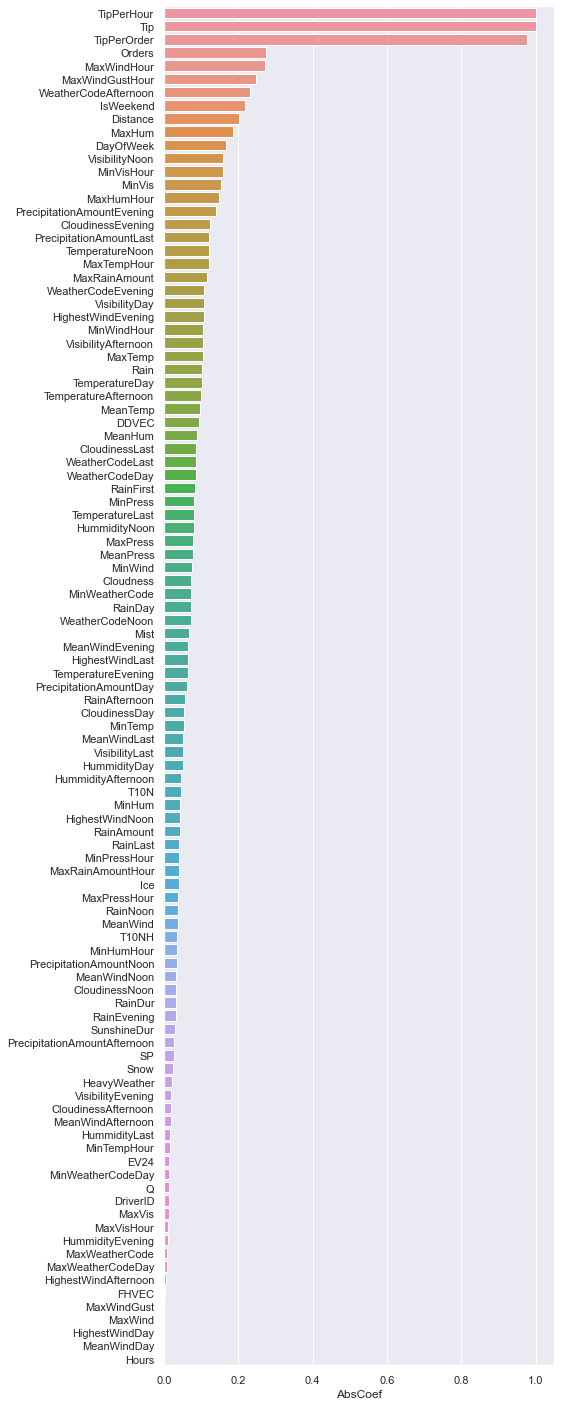

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,25))
sns.set(font_scale=1.4)

cofs = df.corr()[['TipPerHour']]
cofs['AbsCoef'] = cofs['TipPerHour'].apply(abs)

cofs = cofs.sort_values('AbsCoef', ascending=False)

sns.set_theme()
ax = sns.barplot(data=cofs, x='AbsCoef', y=cofs.index)


# Save the file


The last step is to save the file ready for Machine Learning.

In [27]:
cols = ['Date', 'TipPerHour', 'IsWeekend', 'DayOfWeek', 'MaxWindHour', 'MaxWindGustHour', 'MaxHum', 'VisibilityNoon']

df[cols] \
    .to_csv('surfa_combined_dataset.csv', index=None)